In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from fashion_model import FashionCNN 
from manifold_torch import Manifold_Image_Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

def gen_mask(score, ones_ratio = 0.2):
    no_rows, no_cols = score.shape
    score_flat = np.reshape(score, no_rows*no_cols)
    top_k = int(ones_ratio*no_rows*no_cols)
    idx = np.argpartition(score_flat, -top_k)[-top_k:]
    indices = idx[np.argsort((-score_flat)[idx])]
    score_flat_dup = np.zeros_like(score_flat)
    score_flat_dup[indices] = 1.0
    score_dup = score_flat_dup.reshape(no_rows, no_cols)
    return score_dup


# prog_args = arg_parse()

EXPERIMENT = 'fashion_mnist'#
RADIUS = 0.00001 #
NUM_PERTURBATIONS = 10 #
MULTIPLIER = 100 #
DIM = 3 #
# PIVOTS = 10
SHUFFLE = False
BASE_RADIUS = 0.00001
SIM_SIGMA = 1

print("EXPERIMENT: ", EXPERIMENT)
print("RADIUS: ", RADIUS)
print("DIM: ", DIM)
# print("PIVOTS: ", PIVOTS)
print("SHUFFLE: ", SHUFFLE)

EXPERIMENT:  fashion_mnist
RADIUS:  1e-05
DIM:  3
SHUFFLE:  False


In [2]:
if EXPERIMENT == 'fashion_mnist':
    print("Loading fashion mnist")
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    print("Loading mnist")
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

Loading fashion mnist
Done loading


In [3]:
# Train the sampler
all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))

start_time = time.time()
manifold_sampler = Manifold_Image_Sampler(all_images, dim = DIM, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)

# Get the pivots
_ = manifold_sampler.get_pivots(manifold_sampler.labels, MULTIPLIER, shuffle = SHUFFLE, target_labels=None)

Initialize duration:  238.63357090950012


In [4]:
# Get hyperplanes
Gvs = []
for group in torch.unique(manifold_sampler.labels):
    manifold_G = manifold_sampler.get_G_from_samples(manifold_sampler.pivots[group.item()*MULTIPLIER:(group.item()+1)*MULTIPLIER])
    Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)
    Gvs.append(Gv)

sample_to_Gv = {}
group = -1
for i in range(manifold_sampler.pivots.shape[0]):
    if i % MULTIPLIER == 0:
        group = group + 1
    sample_to_Gv[i] = group 

In [5]:
checkpt_file = 'pretrained/fashionCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))
model.eval()
print("Done loading")

pretrained/fashionCNN.pt
Done loading


In [19]:
# Get perturbations
BASE_RADIUS = 0.0001
NUM_PERTURBATIONS = 10
perturbations = []
for _ in range(NUM_PERTURBATIONS):
    for group in torch.unique(manifold_sampler.labels):
        base_batch = manifold_sampler.pivots[group.item()*MULTIPLIER:(group.item()+1)*MULTIPLIER]
        
        # base
        base_gauss_ = np.random.normal(0, 1, size=base_batch.shape)
        r = np.random.uniform()*BASE_RADIUS
        base_gauss_norm = normalize(base_gauss_, r)
        base_pc = manifold_sampler.to_1d(base_batch + base_gauss_norm)
    
        # gauss
        gauss_ = np.random.normal(0, 1, size=base_batch.shape)
        gauss_noise = manifold_sampler.to_1d(gauss_)
        plane_noise = np.zeros_like(gauss_noise)
        for d in range(Gvs[group].shape[0]):
            proj = np.dot(gauss_noise, Gvs[group][d])
            for s in range(plane_noise.shape[0]):
                plane_noise[s] = plane_noise[s] + proj[s]*Gvs[group][d]        
        ortho_noise = gauss_noise - plane_noise
    
        # noise
        r = np.random.uniform()*RADIUS
        ortho_norm = normalize(ortho_noise, r)
        ortho_pc = base_pc + ortho_norm
    
        perturbations.append(manifold_sampler.to_3d(ortho_pc))
    
perturbations = torch.cat(perturbations)    
perturb_embeded = manifold_sampler.transform(perturbations)

In [23]:
index_to_explain = 712
image_to_explain = manifold_sampler.pivots[index_to_explain]

perturb_outputs = model(perturbations.float().to(device))
probs = nn.functional.softmax(perturb_outputs, dim = 1)

original_output = model(image_to_explain.unsqueeze(0).to(device))
original_prob = nn.functional.softmax(original_output, dim = 1)
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
perturb_1st = probs[:,first_prediction.item()].cpu().detach().numpy()
perturb_2nd = probs[:,second_prediction.item()].cpu().detach().numpy()

base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = SIM_SIGMA) for i in range(perturbations.shape[0])]
repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
true_perturb = perturbations - repeat_image_to_explain

no_samples, channels, rows, cols = all_images.shape

clf = linear_model.Ridge(alpha = 200)
clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_1st, sample_weight=similarities)
explanation_1st = -clf.coef_.reshape(rows, cols)
clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_2nd, sample_weight=similarities)
explanation_2nd = -clf.coef_.reshape(rows, cols)


modified_image = image_to_explain.clone().numpy()
modified_mask = gen_mask(explanation_1st - explanation_2nd)
# modified_image[0][modified_mask==1] = np.mean(modified_image)
modified_image[0][modified_mask==1] = 1 - modified_image[0][modified_mask==1]
modified_image = torch.tensor(modified_image)
modified_output = model(modified_image.unsqueeze(0).to(device))
modified_prob = nn.functional.softmax(modified_output, dim = 1)

original_log_odds = np.log(original_prob[0][first_prediction].cpu().detach().numpy()/original_prob[0][second_prediction].cpu().detach().numpy())
modified_log_odds = np.log(modified_prob[0][first_prediction].cpu().detach().numpy()/modified_prob[0][second_prediction].cpu().detach().numpy())
log_odds_score = original_log_odds - modified_log_odds

print(log_odds_score)

21.028278


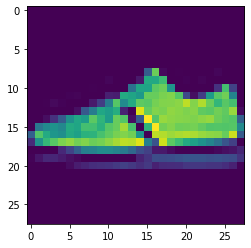

In [24]:
plt.imshow(image_to_explain[0])

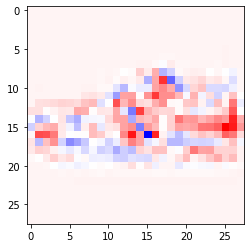

In [26]:
plt.imshow(explanation_1st, cmap = 'bwr')

In [9]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function

import os
import json


In [18]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1)

lr_lime = Lime(
    model, 
    interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

In [19]:
lime_1st = lr_lime.attribute(
    image_to_explain.unsqueeze(0).to(device),
    target=first_prediction,
    n_samples=200,
    perturbations_per_eval=16,
    show_progress=False
).squeeze(0).cpu().detach().numpy()[0]

lime_2nd = lr_lime.attribute(
    image_to_explain.unsqueeze(0).to(device),
    target=second_prediction,
    n_samples=200,
    perturbations_per_eval=16,
    show_progress=False
).squeeze(0).cpu().detach().numpy()[0]

Lime attribution: 100%|████████████████████████| 63/63 [00:00<00:00, 150.71it/s]


In [20]:
modified_image = image_to_explain.clone().numpy()
modified_mask = gen_mask(lime_1st - lime_2nd)
# modified_image[0][modified_mask==1] = np.mean(modified_image)
modified_image[0][modified_mask==1] = 1 - modified_image[0][modified_mask==1]
modified_image = torch.tensor(modified_image)
modified_output = model(modified_image.unsqueeze(0).to(device))
modified_prob = nn.functional.softmax(modified_output, dim = 1)

original_log_odds = np.log(original_prob[0][first_prediction].cpu().detach().numpy()/original_prob[0][second_prediction].cpu().detach().numpy())
modified_log_odds = np.log(modified_prob[0][first_prediction].cpu().detach().numpy()/modified_prob[0][second_prediction].cpu().detach().numpy())
log_odds_score = original_log_odds - modified_log_odds

print(log_odds_score)

12.434628


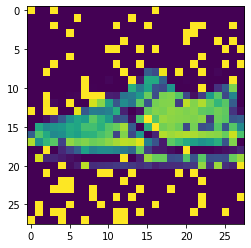

In [21]:
plt.imshow(modified_image[0])

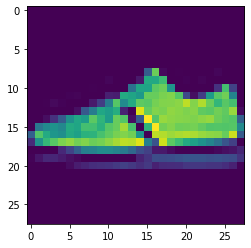

In [22]:
plt.imshow(image_to_explain[0])

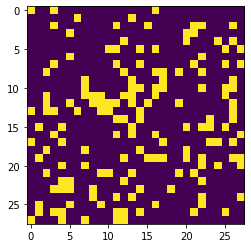

In [23]:
plt.imshow(modified_mask)